## Problem 3 - EM Generated Data

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

In [32]:
class GaussianMixtureEM:
    def __init__(self, n_components, tol=1e-6, max_iters=500):
        self.n_components = n_components
        self.tol = tol
        self.max_iters = max_iters

    def fit(self, X):
        n_samples, n_features = X.shape

        np.random.seed(42)
        self.pi = np.ones(self.n_components) / self.n_components
        # self.means = X[np.random.choice(n_samples, self.n_components, replace=False)]

        sorted_indices = np.argsort(X[:, 0])
        percentiles = np.linspace(20, 80, self.n_components)
        init_indices = []
        for p in percentiles:
            idx = int(np.percentile(np.arange(n_samples), p))
            init_indices.append(sorted_indices[idx])
        self.means = X[init_indices]

        self.covs = [np.cov(X.T) for _ in range(self.n_components)]

        log_likelihood_old = -np.inf

        for iteration in range(self.max_iters):
            # E-STEP
            gamma = np.zeros((n_samples, self.n_components))
            for k in range(self.n_components):
                gamma[:, k] = self.pi[k] * multivariate_normal.pdf(X, self.means[k], self.covs[k])
            gamma = gamma / (gamma.sum(axis=1, keepdims=True) + 1e-10)

            # M-STEP
            N_k = gamma.sum(axis=0)
            self.pi = N_k / n_samples

            for k in range(self.n_components):
                self.means[k] = (gamma[:, k] @ X) / N_k[k]
                diff = X - self.means[k]
                self.covs[k] = (diff.T @ (gamma[:, k, np.newaxis] * diff)) / N_k[k]
                self.covs[k] += np.eye(n_features) * 1e-6

            # Check convergence
            log_likelihood = self.compute_log_likelihood(X)

            if abs(log_likelihood - log_likelihood_old) < self.tol:
                print(f"Converged at iteration {iteration}")
                break

            log_likelihood_old = log_likelihood

        return self

    def compute_log_likelihood(self, X):
        likelihood = np.zeros(len(X))
        for k in range(self.n_components):
            likelihood += self.pi[k] * multivariate_normal.pdf(X, self.means[k], self.covs[k])
        return np.sum(np.log(likelihood + 1e-10))

In [33]:
# def match_components(gmm, true_params):
#     """
#     Match fitted components to true components by closest means
#     """
#     from scipy.optimize import linear_sum_assignment
#
#     n_components = len(true_params)
#     cost_matrix = np.zeros((n_components, n_components))
#
#     # Build cost matrix
#     for i in range(n_components):
#         for j in range(n_components):
#             cost_matrix[i, j] = np.linalg.norm(
#                 gmm.means[i] - true_params[j]['mu']
#             )
#
#     # Find optimal assignment
#     fitted_idx, true_idx = linear_sum_assignment(cost_matrix)
#
#     # Create mapping: fitted_to_true[fitted_component] = true_component
#     fitted_to_true = {}
#     for f, t in zip(fitted_idx, true_idx):
#         fitted_to_true[f] = t
#
#     # Create new arrays in the correct order
#     new_means = np.zeros_like(gmm.means)
#     new_covs = [None] * n_components
#     new_pi = np.zeros_like(gmm.pi)
#
#     # Place each fitted component in its corresponding true position
#     for fitted_comp, true_comp in fitted_to_true.items():
#         new_means[true_comp] = gmm.means[fitted_comp]
#         new_covs[true_comp] = gmm.covs[fitted_comp]
#         new_pi[true_comp] = gmm.pi[fitted_comp]
#
#     # Update gmm with reordered components
#     gmm.means = new_means
#     gmm.covs = new_covs
#     gmm.pi = new_pi
#
#     return gmm

In [34]:
def plot_simple_clusters(X, gmm, true_params, title):
    """
    Simple scatter plot with predicted cluster assignments
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Predict cluster assignments
    gamma = np.zeros((len(X), gmm.n_components))
    for k in range(gmm.n_components):
        gamma[:, k] = gmm.pi[k] * multivariate_normal.pdf(X, gmm.means[k], gmm.covs[k])
    gamma = gamma / (gamma.sum(axis=1, keepdims=True) + 1e-10)
    clusters = np.argmax(gamma, axis=1)

    # Plot 1: Colored by cluster
    scatter = ax1.scatter(X[:, 0], X[:, 1], c=clusters, cmap='viridis', alpha=0.6)
    ax1.set_title(f'{title} - Cluster Assignments')
    ax1.set_xlabel('X1')
    ax1.set_ylabel('X2')
    plt.colorbar(scatter, ax=ax1)

    # Plot 2: Show means and confidence ellipses
    ax2.scatter(X[:, 0], X[:, 1], alpha=0.3, s=10, c='gray')

    # Plot means
    for k in range(gmm.n_components):
        ax2.plot(gmm.means[k][0], gmm.means[k][1], 'o', markersize=15,
                label=f'Component {k+1}')

    # confidence ellipses
    for k in range(gmm.n_components):
        eigenvalues, eigenvectors = np.linalg.eigh(gmm.covs[k])
        angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
        width, height = 2 * 2 * np.sqrt(eigenvalues)  # 2-sigma ellipse

        from matplotlib.patches import Ellipse
        ellipse = Ellipse(gmm.means[k], width, height, angle=angle,
                         facecolor='none', edgecolor=f'C{k}', linewidth=2)
        ax2.add_patch(ellipse)

    ax2.set_title(f'{title} - Means and 2σ Ellipses')
    ax2.set_xlabel('X1')
    ax2.set_ylabel('X2')
    ax2.legend()

    plt.tight_layout()
    plt.show()

In [35]:
def run_problem(filename, n_components, true_params):
    """
    Run EM and compare with true parameters
    """
    X = np.loadtxt(filename)
    print(f"\n{'='*60}")
    print(f"Running EM on {filename}")
    print(f"{'='*60}")

    gmm = GaussianMixtureEM(n_components=n_components)
    gmm.fit(X)

    # Match components to true ordering for 3-gaussian case
    if n_components == 3:
        #gmm = match_components(gmm, true_params)
        print("\n(Components reordered to match true parameters)")

    total_samples = sum([p['n'] for p in true_params])

    print("\nRecovered vs True Parameters:")
    print("-"*40)
    for k in range(n_components):
        true_prior = true_params[k]['n'] / total_samples
        print(f"\nComponent {k+1}:")
        print(f"  Prior: {gmm.pi[k]:.4f} (true: {true_prior:.4f})")
        print(f"  Mean:  [{gmm.means[k][0]:.3f}, {gmm.means[k][1]:.3f}] (true: {true_params[k]['mu']})")
        print(f"  Mean Error: {np.linalg.norm(gmm.means[k] - true_params[k]['mu']):.4f}")

    plot_simple_clusters(X, gmm, true_params, filename.replace('.txt', ''))

    return gmm



Running EM on emMix_data/2gaussian.txt
Converged at iteration 29

Recovered vs True Parameters:
----------------------------------------

Component 1:
  Prior: 0.3348 (true: 0.3333)
  Mean:  [2.994, 3.052] (true: [3 3])
  Mean Error: 0.0524

Component 2:
  Prior: 0.6652 (true: 0.6667)
  Mean:  [7.013, 3.983] (true: [7 4])
  Mean Error: 0.0214


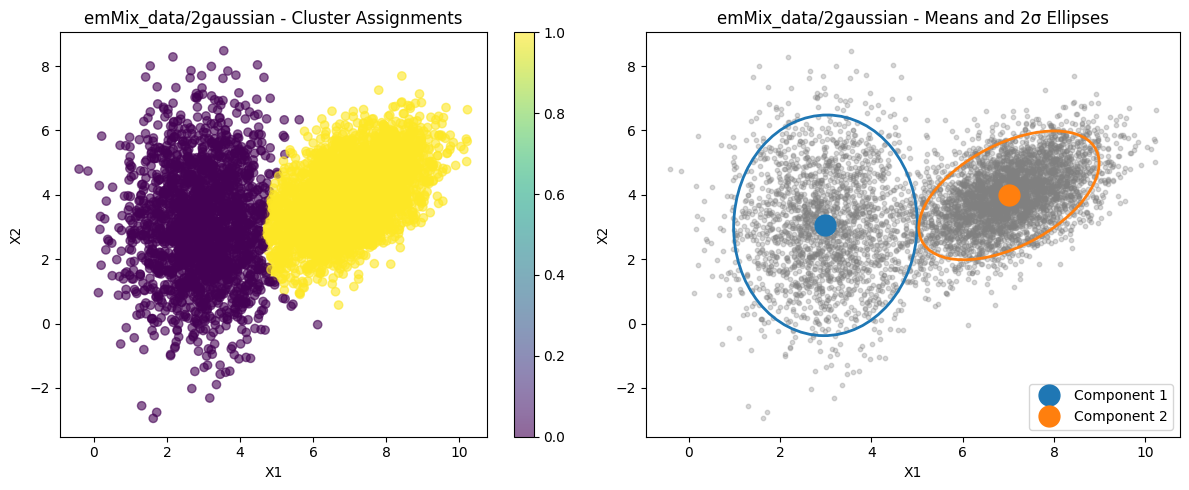


Running EM on emMix_data/3gaussian.txt
Converged at iteration 87

(Components reordered to match true parameters)

Recovered vs True Parameters:
----------------------------------------

Component 1:
  Prior: 0.2056 (true: 0.2000)
  Mean:  [3.040, 3.049] (true: [3 3])
  Mean Error: 0.0628

Component 2:
  Prior: 0.4960 (true: 0.3000)
  Mean:  [5.012, 7.001] (true: [7 4])
  Mean Error: 3.6003

Component 3:
  Prior: 0.2984 (true: 0.5000)
  Mean:  [7.022, 4.015] (true: [5 7])
  Mean Error: 3.6047


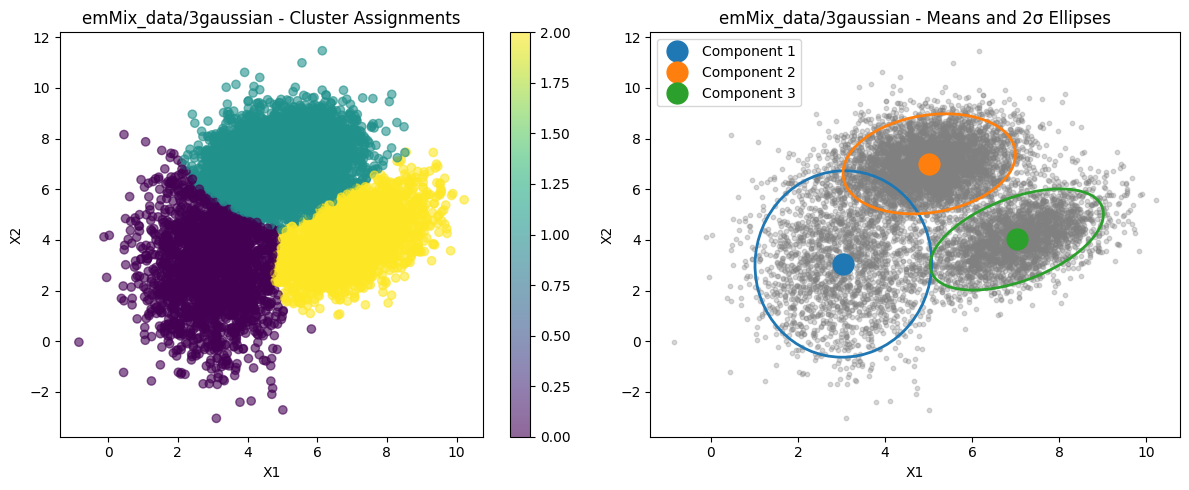

In [36]:
if __name__ == "__main__":
    true_params_2 = [
        {'mu': np.array([3, 3]), 'sigma': np.array([[1, 0], [0, 3]]), 'n': 2000},
        {'mu': np.array([7, 4]), 'sigma': np.array([[1, 0.5], [0.5, 1]]), 'n': 4000}
    ]

    true_params_3 = [
        {'mu': np.array([3, 3]), 'sigma': np.array([[1, 0], [0, 3]]), 'n': 2000},
        {'mu': np.array([7, 4]), 'sigma': np.array([[1, 0.5], [0.5, 1]]), 'n': 3000},
        {'mu': np.array([5, 7]), 'sigma': np.array([[1, 0.2], [0.2, 1]]), 'n': 5000}
    ]

    gmm_2 = run_problem('emMix_data/2gaussian.txt', 2, true_params_2)
    gmm_3 = run_problem('emMix_data/3gaussian.txt', 3, true_params_3)